In [1]:
# работа с данными
import pandas as pd
import numpy as np
#import re

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 12, 6

# библиотека для ускорения pandas
import swifter

# библиотека для расширенной работы с датами
from dateutil.parser import parse
#import time
import datetime

In [2]:
# для работы с предупреждениями
import warnings  
# игнорирование предупреждений
warnings.filterwarnings('ignore')

In [3]:
# вывод всех значений ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [6]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [7]:
nko_data = pd.read_csv('data/nko_data_proba.csv')

In [8]:
nko_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   regionName          747034 non-null  object 
 1   fullName            747034 non-null  object 
 2   dateReg             747034 non-null  int64  
 3   minjustForm         747034 non-null  object 
 4   ogrn                747034 non-null  int64  
 5   egrulStatus         747034 non-null  object 
 6   regionCode          747034 non-null  int64  
 7   incomeTotal         747034 non-null  float64
 8   originDate          747034 non-null  object 
 9   dateLiquid          747034 non-null  object 
 10  hasRegionalSupport  747034 non-null  bool   
 11  dateOgrn            747034 non-null  int64  
 12  opf_name            746619 non-null  object 
 13  opf_code            701825 non-null  float64
 14  mainOkved_name      542353 non-null  object 
 15  mainOkved_code      542353 non-nul

In [9]:
nko_data.rename(columns = {'data_reg' : 'date_reg'}, inplace = True)

### Рассмотрим признаки `regionName` и `regionCode`

In [10]:
nko_data['regionName'].value_counts()

Москва                          80178
Московская область              37927
Санкт-Петербург                 31767
Краснодарский край              23337
Свердловская область            23030
                                ...  
Республика Ингушетия             1249
Еврейская автономная область     1197
Чукотский автономный округ        505
Ненецкий автономный округ         398
Казахстан                          91
Name: regionName, Length: 86, dtype: int64

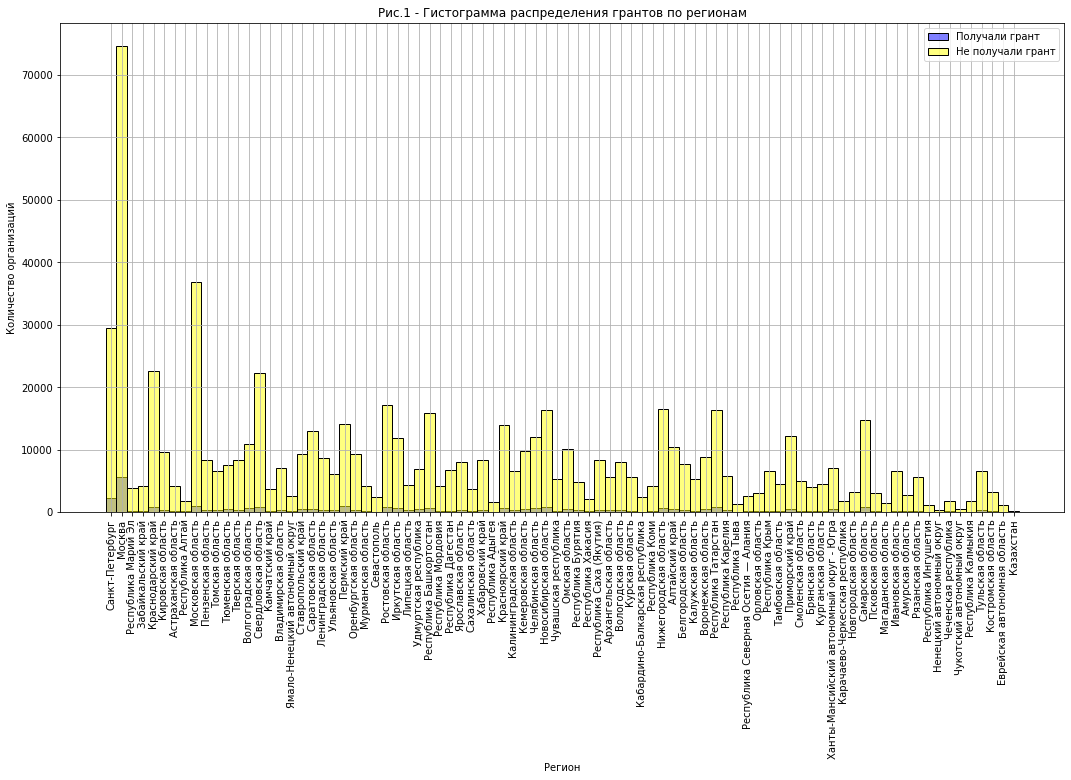

In [11]:
# Задаем размер графика
fig_1, axes_1 = plt.subplots(figsize=(18, 9))
# определяем гистограмму распределения
histplot = sns.histplot(
    data=nko_data, 
    x='regionName', 
    hue='grant',
    ax=axes_1,
    palette=['yellow', 'blue']
)
histplot.set_title('Рис.1 - Гистограмма распределения грантов по регионам')
histplot.set_ylabel('Количество организаций')
histplot.set_xlabel('Регион')
histplot.legend(['Получали грант', 'Не получали грант'])
for tick in histplot.get_xticklabels():
    tick.set_rotation(90)

histplot.grid();

In [12]:
region_grant = nko_data.groupby(['regionName'])[
    ['grant']].mean().sort_values(by='grant', ascending=False)
region_grant

,grant
regionName,
Ненецкий автономный округ,0.077889
Санкт-Петербург,0.071961
Республика Алтай,0.070365
Москва,0.069670
Ханты-Мансийский автономный округ - Югра,0.068574
...,...
Московская область,0.027368
Республика Дагестан,0.027050
Ивановская область,0.026153


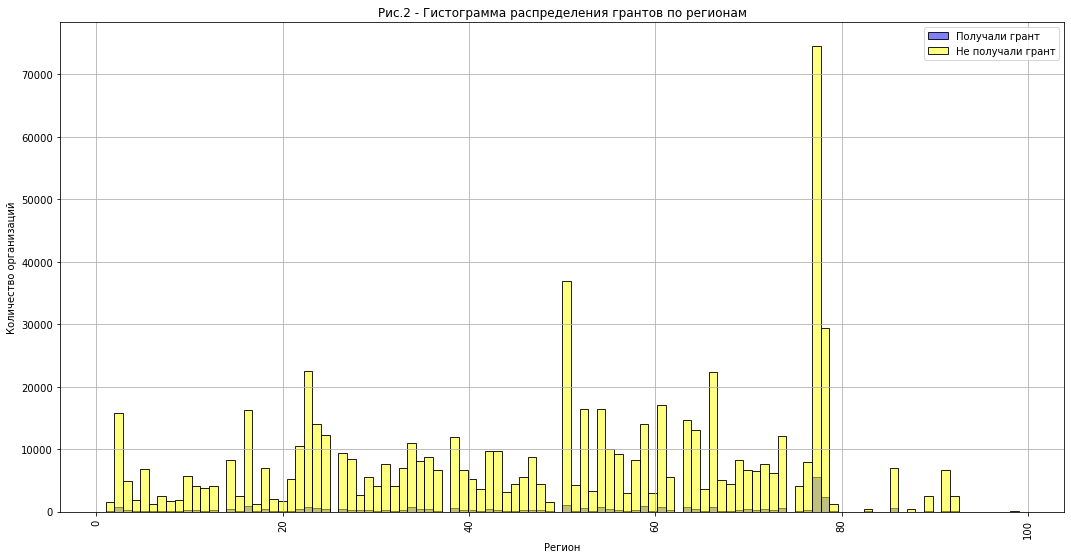

In [13]:
# Задаем размер графика
fig_2, axes_2 = plt.subplots(figsize=(18, 9))
# определяем гистограмму распределения
histplot_2 = sns.histplot(
    data=nko_data, 
    x='regionCode', 
    hue='grant',
    ax=axes_2,
    palette=['yellow', 'blue']
)
histplot_2.set_title('Рис.2 - Гистограмма распределения грантов по регионам')
histplot_2.set_ylabel('Количество организаций')
histplot_2.set_xlabel('Регион')
histplot_2.legend(['Получали грант', 'Не получали грант'])
for tick in histplot_2.get_xticklabels():
    tick.set_rotation(90)

histplot_2.grid();

In [14]:
region_code_grant = nko_data.groupby(['regionCode'])[
    ['grant']].mean().sort_values(by='grant', ascending=False)
region_code_grant

,grant
regionCode,
83,0.077889
78,0.071961
4,0.070365
77,0.069670
86,0.068574
...,...
50,0.027368
5,0.027050
37,0.026153


In [15]:
# удаляем regionName, т.к. он дублирует regionCode
nko_data.drop(['regionName'], axis=1, inplace=True)

In [16]:
# удаляем fullName и ogrn, т.к. они уникальны для каждой организации
nko_data.drop(['fullName', 'ogrn'], axis=1, inplace=True)

### Работа с датами: `dateReg`, `originDate`, `dateLiquid`, `dateOgrn`, `date_reg`

Признаки `dateReg` и `dateOgrn` заполнены 0 и 1. `dateReg` - обозначает была ли зарегестрирована организация до 2002 года. `dateOgrn` - показывалит была ли зарегестрирована организация после 2002 года.

In [17]:
# удаляем originDate, т.к. он дублирует data_reg
nko_data.drop(['originDate'], axis=1, inplace=True)

`date_reg` сформирована на основании данных о регистрации компаний до 2002 года и после 2002 года, за основу взяты даты после 2002 года (то есть `dateOgrn`) и при конфликтных ситуациях бралась более свежая дата.

In [18]:
#nko_df = nko_data.copy(deep=True)

In [19]:
#nko_data['date_reg'] = nko_df['date_reg']
#nko_data['dateLiquid'] = nko_df['dateLiquid']

Есть организации, которые при изменении порядка регистрации, ликвидировали и в тот же день заново зарегистрировали компанию. Поэтому при вичисление срока жизни организации можно посчитать, что орагнизация проработала 0 дней. Для таких организаций не стали учитывать дату ликвидации, считая, что они работаю до сих пор.

In [20]:
nko_data.loc[(nko_data['dateReg'] == 1) & (nko_data['dateOgrn']
                                           == 1), 'dateLiquid'] = '2022-08-01T00:00:00.000Z'

In [21]:
# приведем даты к типу datetime
nko_data['date_reg'] = nko_data['date_reg'].swifter.apply(
        lambda x: parse(x, fuzzy=True))

nko_data['dateLiquid'] = nko_data['dateLiquid'].swifter.apply(
        lambda x: '2022-08-01T00:00:00.000Z' if x == 'not data' else x)
nko_data['dateLiquid'] = nko_data['dateLiquid'].swifter.apply(
        lambda x: parse(x, fuzzy=True))

Pandas Apply:   0%|          | 0/747034 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/747034 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/747034 [00:00<?, ?it/s]

In [22]:
nko_data['date_reg'] = pd.to_datetime(nko_data['date_reg'])
nko_data['date_reg'] = nko_data['date_reg'].swifter.apply(
    lambda x: datetime.datetime.date(x))

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [23]:
nko_data['dateLiquid'] = pd.to_datetime(nko_data['dateLiquid'])
nko_data['dateLiquid'] = nko_data['dateLiquid'].swifter.apply(
    lambda x: datetime.datetime.date(x))

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [24]:
nko_data['nko_live'] = nko_data['dateLiquid'] - nko_data['date_reg']
nko_data['nko_live'] = nko_data['nko_live'].swifter.apply(lambda x: x.days)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

In [25]:
nko_data = nko_data[nko_data['nko_live'] >= 0]

In [26]:
nko_data['year_reg'] = nko_data['date_reg'].swifter.apply(lambda x: x.year/365)

Pandas Apply:   0%|          | 0/747030 [00:00<?, ?it/s]

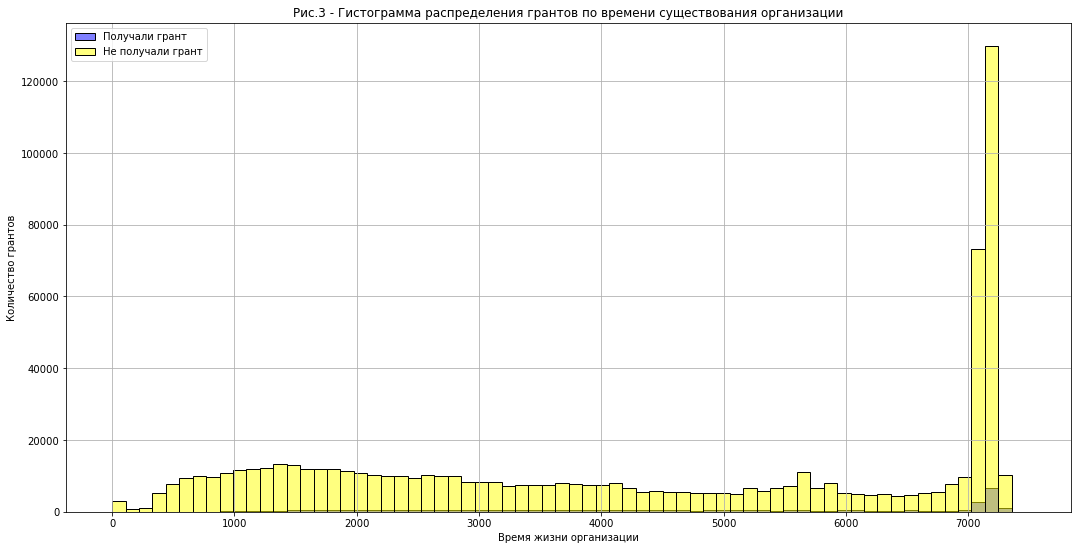

In [27]:
# Задаем размер графика
fig_3, axes_3 = plt.subplots(figsize=(18, 9))
# определяем гистограмму распределения
histplot_3 = sns.histplot(
    data=nko_data, 
    x='nko_live', 
    hue='grant',
    ax=axes_3,
    palette=['yellow', 'blue']
)
histplot_3.set_title('Рис.3 - Гистограмма распределения грантов по времени существования организации')
histplot_3.set_ylabel('Количество грантов')
histplot_3.set_xlabel('Время жизни организации')
histplot_3.legend(['Получали грант', 'Не получали грант'])
#for tick in histplot.get_xticklabels():
#    tick.set_rotation(90)

histplot_3.grid();

In [28]:
# удаляем dateLiquid, date_reg, т.к. они больше не нужны
nko_data.drop(['dateLiquid', 'date_reg'], axis=1, inplace=True)

### Рассмотрим признак `minjustForm`

In [29]:
nko_data['minjustForm'].value_counts()

общественная или религиозная организация                               150999
недвижимость                                                           132950
некоммерческие организации и фонды                                      75913
потребительские организации                                             62872
профессиональные и профсоюзные организации                              57656
автономная некоммерческая организация                                   57385
садоводческие, огороднические или дачные некоммерческие организации     41102
религиозная организация                                                 36573
учреждение                                                              26764
объединения юридических лиц                                             18816
сельскохозяйственные организации                                        12442
общественный фонд                                                        9289
политическая партия                                             

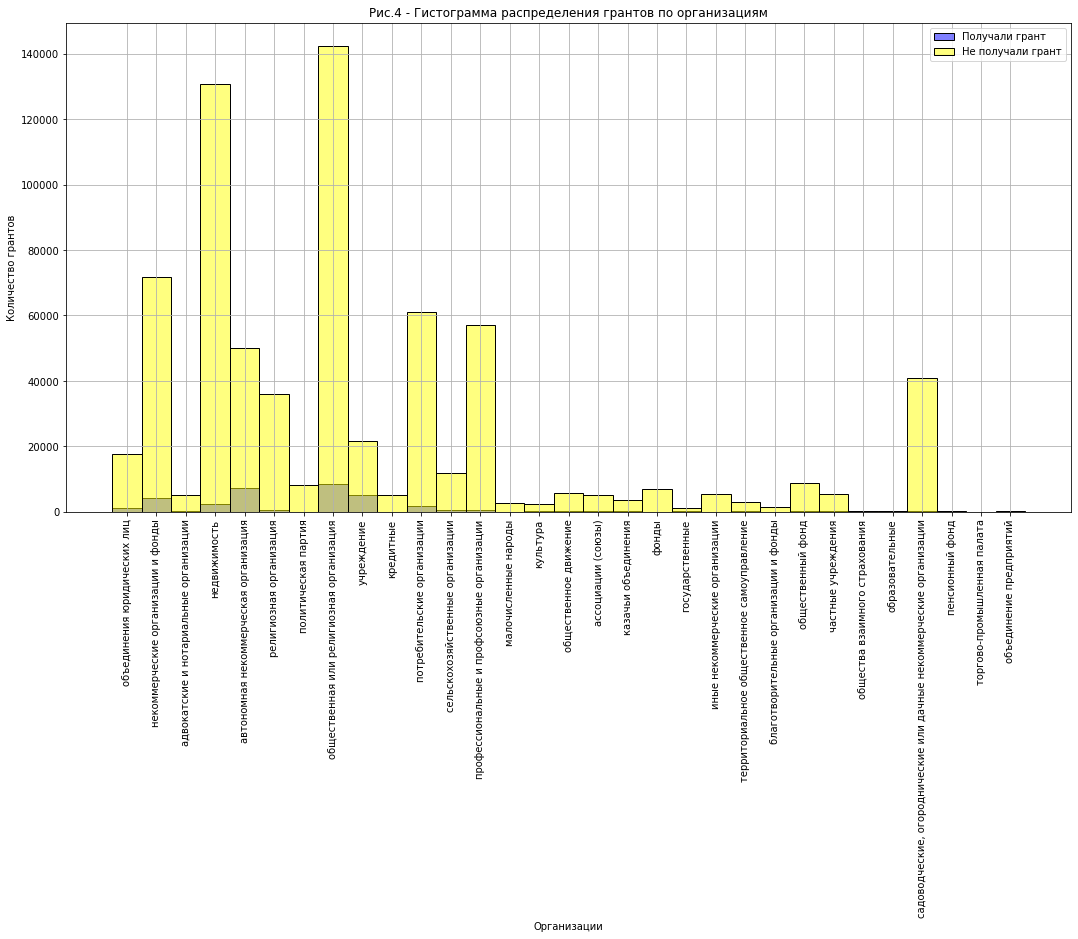

In [30]:
# Задаем размер графика
fig_4, axes_4 = plt.subplots(figsize=(18, 9))
# определяем гистограмму распределения
histplot_4 = sns.histplot(
    data=nko_data, 
    x='minjustForm', 
    hue='grant',
    ax=axes_4,
    palette=['yellow', 'blue']
)
histplot_4.set_title('Рис.4 - Гистограмма распределения грантов по организациям')
histplot_4.set_ylabel('Количество грантов')
histplot_4.set_xlabel('Организации')
histplot_4.legend(['Получали грант', 'Не получали грант'])
for tick in histplot_4.get_xticklabels():
    tick.set_rotation(90)

histplot_4.grid();

In [31]:
minjustForm_grant = nko_data.groupby(['minjustForm'])[
    ['grant']].mean().sort_values(by='grant', ascending=False)
minjustForm_grant

,grant
minjustForm,
торгово-промышленная палата,0.488372
государственные,0.200000
учреждение,0.186108
автономная некоммерческая организация,0.125155
объединения юридических лиц,0.063722
казачьи объединения,0.060200
общественная или религиозная организация,0.057053
сельскохозяйственные организации,0.056100
некоммерческие организации и фонды,0.054865


### Рассмотрим признак `egrulStatus`

In [32]:
nko_data['egrulStatus'].value_counts()

Ликвидирована    406130
Действует        340900
Name: egrulStatus, dtype: int64

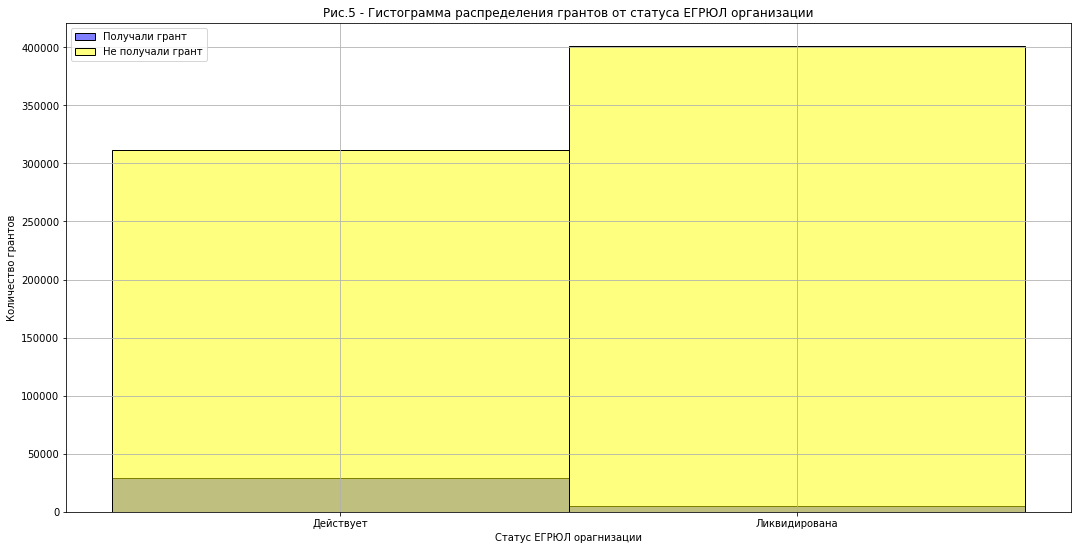

In [33]:
# Задаем размер графика
fig_5, axes_5 = plt.subplots(figsize=(18, 9))
# определяем гистограмму распределения
histplot_5 = sns.histplot(
    data=nko_data, 
    x='egrulStatus', 
    hue='grant',
    ax=axes_5,
    palette=['yellow', 'blue']
)
histplot_5.set_title('Рис.5 - Гистограмма распределения грантов от статуса ЕГРЮЛ организации')
histplot_5.set_ylabel('Количество грантов')
histplot_5.set_xlabel('Статус ЕГРЮЛ орагнизации')
histplot_5.legend(['Получали грант', 'Не получали грант'])
#for tick in histplot_5.get_xticklabels():
#    tick.set_rotation(90)

histplot_5.grid();

In [34]:
egrulStatus_grant = nko_data.groupby(['egrulStatus'])[
    ['grant']].mean().sort_values(by='grant', ascending=False)
egrulStatus_grant

,grant
egrulStatus,
Действует,0.086254
Ликвидирована,0.012068


In [35]:
# преобразуем, для последующей работы с МО
nko_data['egrulStatus'] = nko_data['egrulStatus'].map(
    {'Действует': 1, 'Ликвидирована': 0})

### Рассмотрим признак `hasRegionalSupport`

In [36]:
nko_data['hasRegionalSupport'].value_counts()

False    735765
True      11265
Name: hasRegionalSupport, dtype: int64

In [37]:
regSup_grant = nko_data.groupby(['hasRegionalSupport'])[
    ['grant']].mean().sort_values(by='grant', ascending=False)
regSup_grant

,grant
hasRegionalSupport,
True,0.410475
False,0.040340


In [38]:
# преобразуем, для последующей работы с МО
nko_data['hasRegionalSupport'] = nko_data['hasRegionalSupport'].map(
    {True: 1, False: 0})

### Рассмотрим признак `incomeTotal`

In [42]:
nko_data['incomeTotal'].sample(10)

614721          0.00
354882          0.00
254713          0.00
706177          0.00
339672    8443809.86
622084          0.00
693617          0.00
208861          0.00
590655          0.00
47045           0.00
Name: incomeTotal, dtype: float64

Разброс в признаке сишком большой, поэтому логарифмируем признак

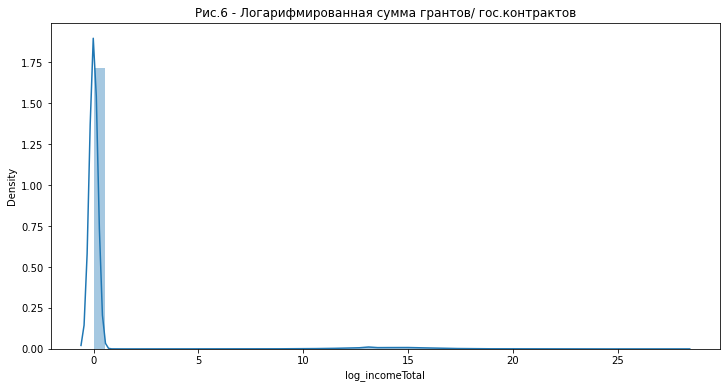

In [40]:
# добавим логарифмированный признак
nko_data['log_incomeTotal'] = np.log(nko_data.incomeTotal + 1)

sns.distplot(nko_data['log_incomeTotal'])
plt.title('Рис.6 - Логарифмированная сумма грантов/ гос.контрактов')
plt.show();

In [43]:
# удаляем incomeTotal
nko_data.drop(['incomeTotal'], axis=1, inplace=True)

### Рассмотрим признак `opf_code`

In [44]:
nko_data['opf_code'].fillna(0, inplace=True)
nko_data['opf_code'] = nko_data['opf_code'].astype(int)

In [45]:
nko_data['opf_code'].value_counts()

20200    75444
83       72797
20101    49868
71400    46107
0        45209
         ...  
56           1
61           1
14155        1
68           1
65000        1
Name: opf_code, Length: 159, dtype: int64

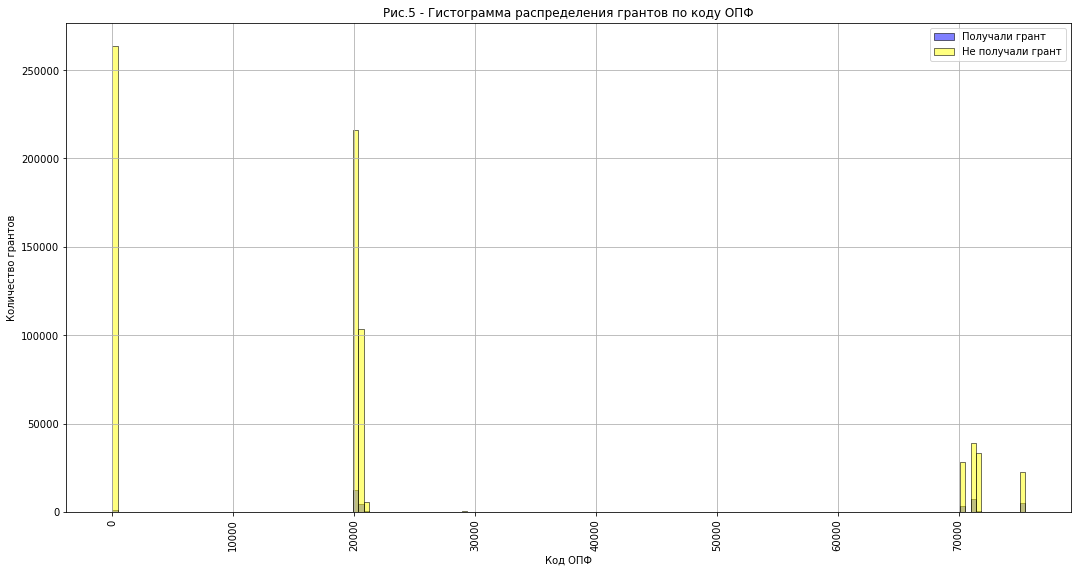

In [46]:
# Задаем размер графика
fig_7, axes_7 = plt.subplots(figsize=(18, 9))
# определяем гистограмму распределения
histplot_7 = sns.histplot(
    data=nko_data, 
    x='opf_code', 
    hue='grant',
    ax=axes_7,
    palette=['yellow', 'blue']
)
histplot_7.set_title('Рис.5 - Гистограмма распределения грантов по коду ОПФ')
histplot_7.set_ylabel('Количество грантов')
histplot_7.set_xlabel('Код ОПФ')
histplot_7.legend(['Получали грант', 'Не получали грант'])
for tick in histplot_7.get_xticklabels():
    tick.set_rotation(90)

histplot_7.grid();

In [47]:
opf_code_grant = nko_data.groupby(['opf_code'])[
    ['grant']].mean().sort_values(by='grant', ascending=False)
opf_code_grant.head(10)

,grant
opf_code,
75204,1.000000
75300,1.000000
65243,0.666667
75201,0.600000
20611,0.588235
65242,0.500000
75104,0.400000
75103,0.366667
75203,0.315789


In [48]:
# удаляем opf_name
nko_data.drop(['opf_name'], axis=1, inplace=True)

### Рассмотрим признак `mainOkved_code` и `mainOkved_name`

In [49]:
nko_data['mainOkved_code'].value_counts()

94.99       76871
52.21.24    38247
94.91       31456
68.32.1     29643
91.33       24328
            ...  
46.33.2         1
65.12.1         1
64.11.14        1
64.91.2         1
28.72           1
Name: mainOkved_code, Length: 2040, dtype: int64

In [50]:
nko_data['mainOkved_code'].fillna('0', inplace=True)

In [51]:
nko_data['mainOkved_code'].value_counts()[:10]

0           204677
94.99        76871
52.21.24     38247
94.91        31456
68.32.1      29643
91.33        24328
68.32.2      22989
68.32        20858
70.32.1      19131
94.20        18320
Name: mainOkved_code, dtype: int64

In [54]:
mainOkved_code_grant = nko_data.groupby(['mainOkved_code'])[
    ['grant']].mean().sort_values(by='grant', ascending=False)
mainOkved_code_grant.sample(10)

,grant
mainOkved_code,
60.24.2,0.000000
46.18,0.000000
46.21.19,0.060000
71.12.63,0.071429
67.20.3,0.000000
47.19,0.345725
35.11,0.030303
16.1,0.000000
01.16.3,0.000000


In [55]:
nko_data['mainOkved_name'].isna().sum()

204677

In [56]:
nko_data['mainOkved_name'].fillna('not data', inplace=True)

In [58]:
nko_data['mainOkved_name'].value_counts()

not data                                                                                       204677
Деятельность прочих общественных организаций, не включенных в другие группировки               101190
Деятельность стоянок для транспортных средств                                                   38247
Деятельность религиозных организаций                                                            32517
Управление эксплуатацией жилого фонда за вознаграждение или на договорной основе                29643
                                                                                                ...  
Производство красок и лаков на основе полимеров                                                     1
Оптовая торговля мукой и макаронными изделиями                                                      1
Деятельность по оказанию прочих услуг, связанных со службой предварительных заказов                 1
Производство передающей аппаратуры, аппаратуры для проводной телефонной и телеграф

In [61]:
mainOkved_name_grant = nko_data.groupby(['mainOkved_name'])[
    ['grant']].mean().sort_values(by='grant', ascending=False)
mainOkved_name_grant.head(10)

,grant
mainOkved_name,
Деятельность морского транспорта,0.000000
"Предоставление кредитов на покупку домов специализированными учреждениями, не принимающими депозиты",0.000000
Розничная торговля текстильными и галантерейными изделиями,0.000000
"Деятельность, связанная со сбором, обработкой и подготовкой картографической и космической информации, включая аэросъемку",0.000000
Деятельность профессиональных членских организаций,0.074361
Деятельность морского грузового транспорта,0.000000
"Производство готовых кормов для животных, содержащихся на фермах",0.046154
Производство фармацевтических субстанций,0.000000
"Деятельность прочего сухопутного пассажирского транспорта, подчиняющегося расписанию",0.000000


В признаках слишком много значений, так как мы уже обработали "форму НКО, согласно Минюсту". Эти признаки удаляем.

In [63]:
# удаляем mainOkved_code', 'mainOkved_name'
nko_data.drop(['mainOkved_code', 'mainOkved_name'], axis=1, inplace=True)

In [65]:
# удаляем index_address, т.к. он дублирует частично код региона
nko_data.drop(['index_address'], axis=1, inplace=True)

### Рассмотрим признак `okogu_name` и `okogu_code`

In [69]:
nko_data['okogu_name'].value_counts()[:10]

Организации, учрежденные юридическими лицами или гражданами, или юридическими лицами и гражданами совместно                                     219085
Региональные и местные общественные объединения                                                                                                  87093
Другие хозяйствующие субъекты                                                                                                                    31356
Межрегиональные общественные объединения                                                                                                          2717
Центральный союз потребительских обществ Российской Федерации                                                                                     2593
Казачьи общества, созданные в форме некоммерческой организации и внесенные  в государственный реестр казачьих обществ в Российской Федерации      2459
Общероссийские общественные объединения                                                       

In [70]:
list_okogu_name = list(nko_data['okogu_name'].value_counts()[:10].index)
nko_data['okogu_name'] = nko_data['okogu_name'].apply(
    lambda x: x if x in list_okogu_name else 'Иные организации')

In [71]:
nko_data['okogu_name'] = nko_data['okogu_name'].swifter.apply(
    lambda x: 'Организации, учрежденные юридическими лицами и гражданами' if x == 'Организации, учрежденные юридическими лицами или гражданами, или юридическими лицами и гражданами совместно' else x)
nko_data['okogu_name'] = nko_data['okogu_name'].swifter.apply(
    lambda x: 'Казачьи общества' if x == 'Казачьи общества, созданные в форме некоммерческой организации и внесенные  в государственный реестр казачьих обществ в Российской Федерации' else x)
nko_data['okogu_name'] = nko_data['okogu_name'].swifter.apply(
    lambda x: 'ОАО "РЖД"' if x == 'Открытое акционерное общество "Российские железные дороги"' else x)

Pandas Apply:   0%|          | 0/747030 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/747030 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/747030 [00:00<?, ?it/s]

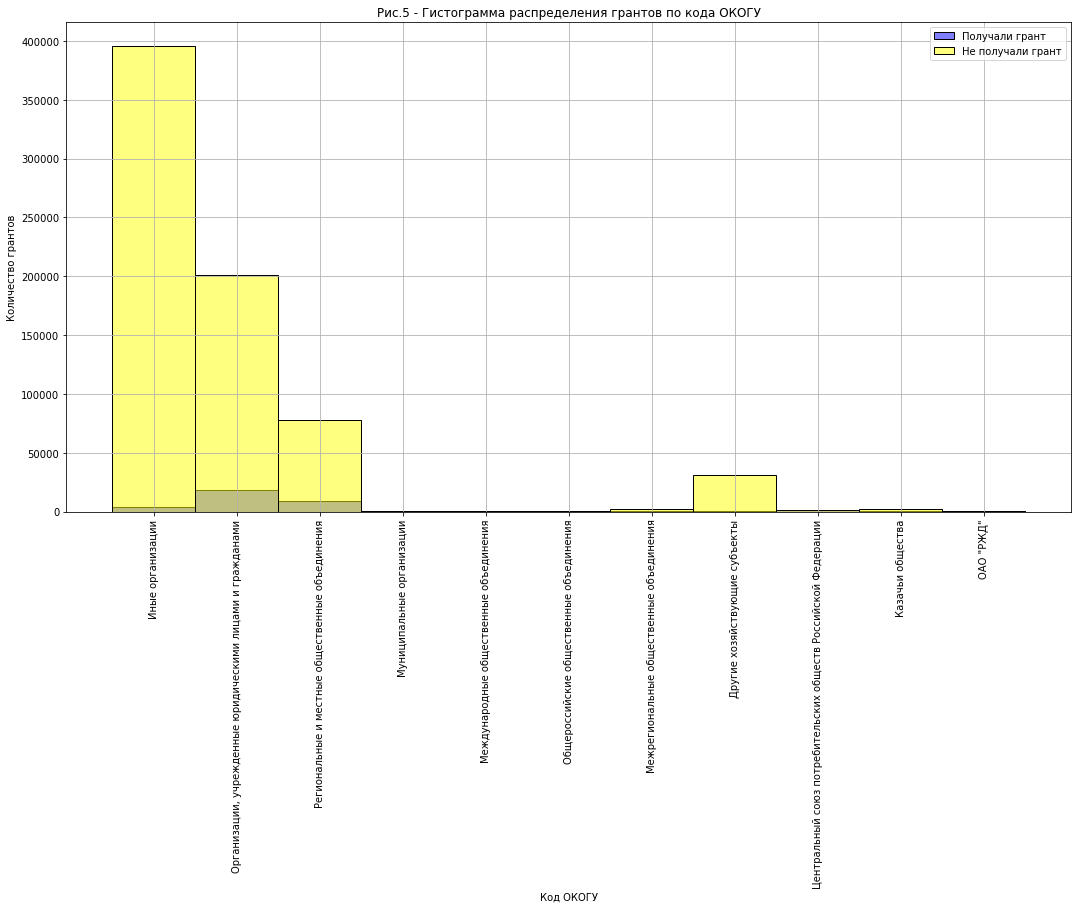

In [72]:
# Задаем размер графика
fig_8, axes_8 = plt.subplots(figsize=(18, 9))
# определяем гистограмму распределения
histplot_8 = sns.histplot(
    data=nko_data, 
    x='okogu_name', 
    hue='grant',
    ax=axes_8,
    palette=['yellow', 'blue']
)
histplot_8.set_title('Рис.5 - Гистограмма распределения грантов по кода ОКОГУ')
histplot_8.set_ylabel('Количество грантов')
histplot_8.set_xlabel('Код ОКОГУ')
histplot_8.legend(['Получали грант', 'Не получали грант'])
for tick in histplot_8.get_xticklabels():
    tick.set_rotation(90)

histplot_8.grid();

In [73]:
okogu_name_grant = nko_data.groupby(['okogu_name'])[
    ['grant']].mean().sort_values(by='grant', ascending=False)
okogu_name_grant.head()

,grant
okogu_name,
"ОАО ""РЖД""",0.823770
Центральный союз потребительских обществ Российской Федерации,0.415349
Общероссийские общественные объединения,0.305772
Муниципальные организации,0.256410
Международные общественные объединения,0.241007


In [75]:
okogu_code_grant = nko_data.groupby(['okogu_code'])[
    ['grant']].mean().sort_values(by='grant', ascending=False)
okogu_code_grant.head()

,grant
okogu_code,
4100103.0,1.0
2300225.0,1.0
4100401.0,1.0
4100307.0,1.0
4100306.0,1.0


In [76]:
# удаляем okogu_code, т.к. показывает странные значения
nko_data.drop(['okogu_code'], axis=1, inplace=True)

Закодируем признаки `opf_code`, `okogu_name` с помощью `OneHotEncoder`.

In [82]:
from sklearn.preprocessing import OneHotEncoder

In [85]:
ohc = OneHotEncoder()
df_ohc = pd.DataFrame()
for col in ['minjustForm', 'okogu_name']:
    ohe = ohc.fit_transform(nko_data[col].values.reshape(-1,1)).toarray()
    dfOneHot = pd.DataFrame(ohe, columns=[str(ohc.categories_[0][i])
                                          for i in range(len(ohc.categories_[0]))])
    df_ohc = pd.concat([df_ohc, dfOneHot], axis=1)

In [86]:
df_ohc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747030 entries, 0 to 747029
Data columns (total 42 columns):
 #   Column                                                               Non-Null Count   Dtype  
---  ------                                                               --------------   -----  
 0   автономная некоммерческая организация                                747030 non-null  float64
 1   адвокатские и нотариальные организации                               747030 non-null  float64
 2   ассоциации (союзы)                                                   747030 non-null  float64
 3   благотворительные организации и фонды                                747030 non-null  float64
 4   государственные                                                      747030 non-null  float64
 5   иные некоммерческие организации                                      747030 non-null  float64
 6   казачьи объединения                                                  747030 non-null  float6

In [89]:
ohc_cols = list(df_ohc.columns)

In [90]:
# добавляем новые признаки к датасету
nko_data_new = pd.concat([nko_data, df_ohc], axis=1)

In [91]:
# Создадим списки признаков в зависимости от их типа:

# категориальные признаки
cols_cat = ['opf_code', 'regionCode']

# бинарные признаки
cols_bin = ['dateReg', 'egrulStatus',
            'hasRegionalSupport', 'dateOgrn']
# числовые признаки
cols_num = ['num_of_addOkved', 'nko_live',
            'year_reg', 'log_incomeTotal']

# целевая переменная
col_target = ['grant']

<Figure size 1152x864 with 0 Axes>

<AxesSubplot:>

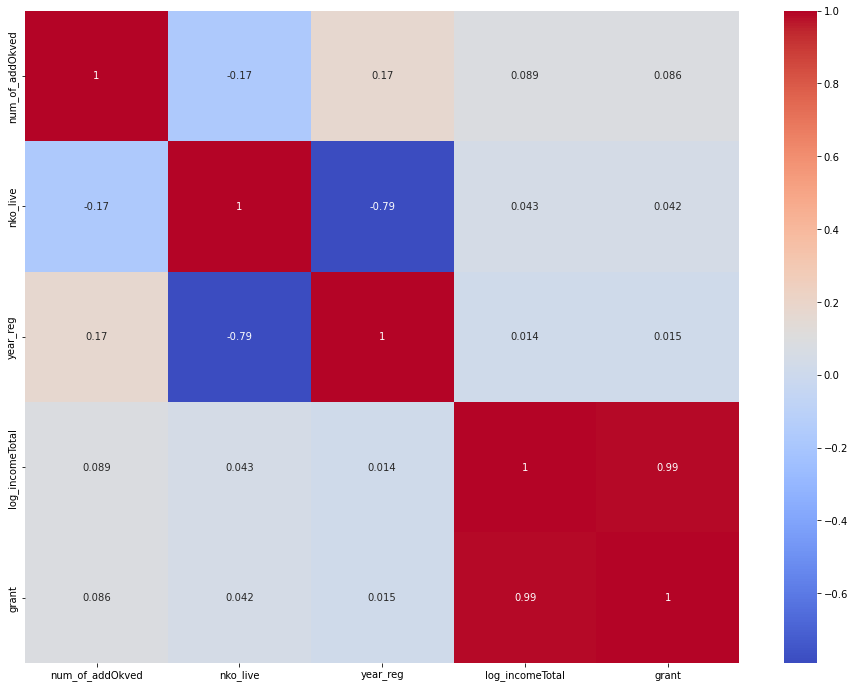

In [92]:
# посмотрим таблицу корреляции по всем числовым признакам
cor_cols_num = cols_num + col_target
correlation = nko_data_new[cor_cols_num].corr(method='pearson').round(decimals=3)

plt.figure(figsize=(16, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [93]:
# удалим из списка log_incomeTotal, так как он дублирует нашу целевую переменную
cols_num.remove('log_incomeTotal')

<Figure size 1152x864 with 0 Axes>

<AxesSubplot:>

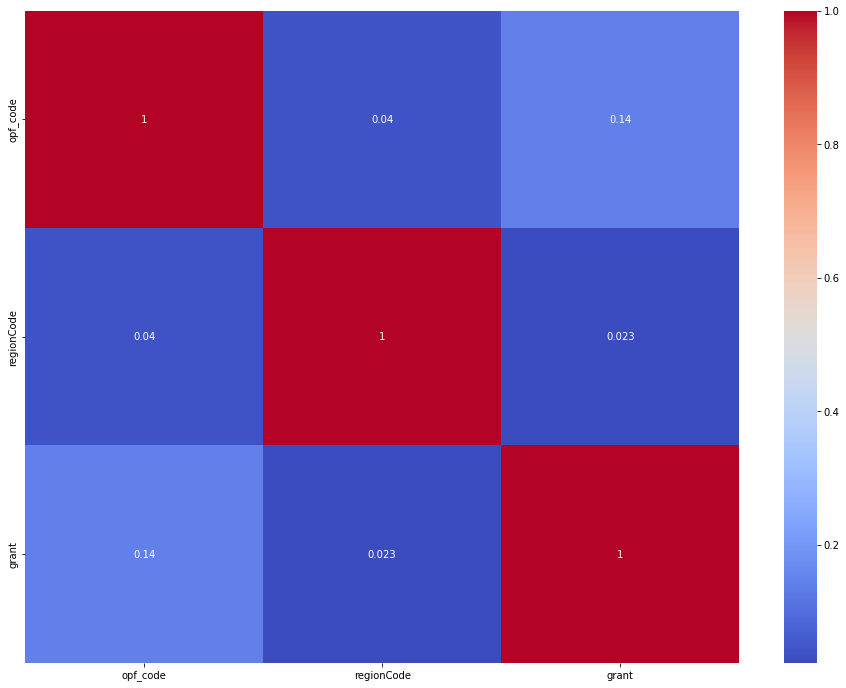

In [94]:
# посмотрим таблицу корреляции по всем категориальным признакам
cor_cols_cat = cols_cat + col_target
corr_cat = nko_data_new[cor_cols_cat].corr(method='kendall').round(decimals=3)

plt.figure(figsize=(16, 12))
sns.heatmap(corr_cat, annot=True, cmap='coolwarm')

Видим слабую корреляцию с целевой переменной

<Figure size 1152x864 with 0 Axes>

<AxesSubplot:>

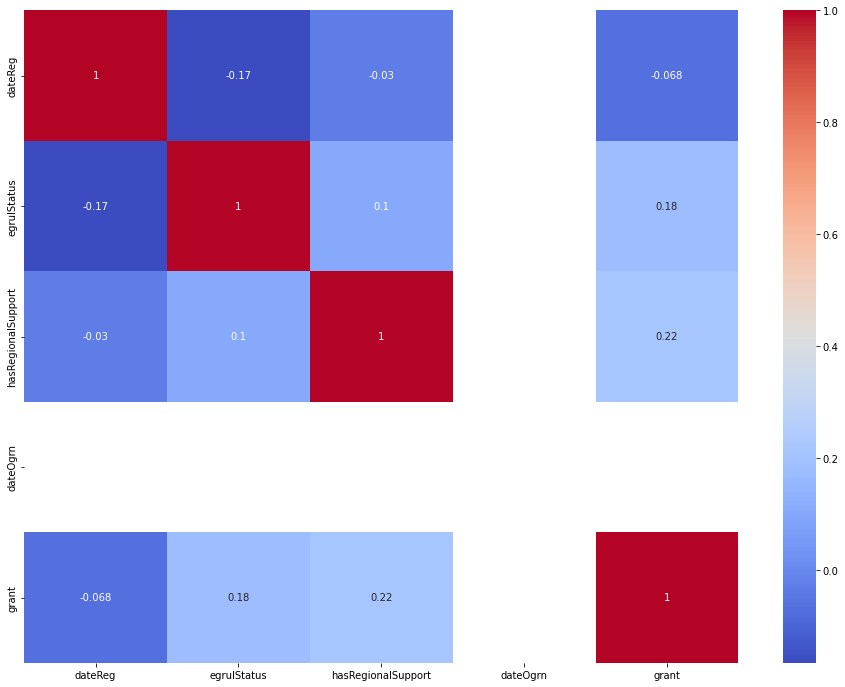

In [96]:
# посмотрим таблицу корреляции по всем бинарным признакам
cor_cols_bin = cols_bin + col_target
corr_bin = nko_data_new[cor_cols_bin].corr(method='spearman').round(decimals=3)

plt.figure(figsize=(16, 12))
sns.heatmap(corr_bin, annot=True, cmap='coolwarm')

Видим слабую корреляцию с целевой переменной

In [119]:
# Сохраняем полученные данные в файл, чтобы не проходить всю обработку снова
nko_data_new.to_csv('data/nko_data_finish.csv', index=False)

### Предсказание с помощью библиотеки LightAutoML

In [97]:
# Импортируем необходимые библиотеки

import time

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML #, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [98]:
N_THREADS = 6
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 3600
TARGET_NAME = 'grant'

In [99]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [106]:
nko_data_new['grant'].fillna(0, inplace=True)

In [120]:
# удаляем log_incomeTotal, т.к. он дублирует нашу целевую переменную
nko_data_new.drop(['log_incomeTotal'], axis=1, inplace=True)

In [121]:
# Создадим тренировочную и валидационную выборки
df_train, df_val = train_test_split(nko_data_new,
                                    test_size=TEST_SIZE,
                                    shuffle=True,
                                    random_state=RANDOM_STATE)

In [122]:
roles_df = {
    'target': TARGET_NAME
}

In [123]:
def f1_metric(y_true, y_pred, **kwargs):
    return f1_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

In [124]:
automl = TabularAutoML(
    task=Task('binary', metric=f1_metric),
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS,
                   'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [ ]:
%%time 
oof_pred = automl.fit_predict(df_train, roles = roles_df, verbose = 1)

[08:44:40] Stdout logging level is INFO.
[08:44:40] Task: binary

[08:44:40] Start automl preset with listed constraints:
[08:44:40] - time: 3600.00 seconds
[08:44:40] - CPU: 6 cores
[08:44:40] - memory: 16 GB

[08:44:40] Train data shape: (597627, 54)

[08:44:57] Layer 1 train process start. Time left 3583.20 secs


In [ ]:
%%time

te_pred = automl.predict(df_val)
print(f'Предсказание для тестовых данных:\n{te_pred}\nРазмер = {te_pred.shape}')

In [ ]:
print(f'Точность модели  на тренировочных данных: {(f1_metric(df_train[TARGET_NAME].values, oof_pred.data[:, 0])):0.2f}')
print(f'Точность итогового предсказания: {(f1_metric(df_val[TARGET_NAME].values, te_pred.data[:, 0])):0.2f}')

In [ ]:
print(automl.create_model_str_desc())

### Расчет важности признаков

In [ ]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = Task('binary', metric=f1_metric), 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [ ]:
%%time
oof_pred_rd = automl_rd.fit_predict(df_train, roles=roles_df, verbose=1)

In [ ]:
%%time

te_pred_rd = automl_rd.predict(df_val)
print(f'Предсказание для тестовых данных:\n{te_pred_rd}\nРазмер = {te_pred_rd.shape}')

In [ ]:
print(f'Точность модели  на тренировочных данных: {(f1_metric(df_train[TARGET_NAME].values, oof_pred_rd.data[:, 0])):0.2f}')
print(f'Точность итогового предсказания: {(f1_metric(df_val[TARGET_NAME].values, te_pred_rd.data[:, 0])):0.2f}')

In [ ]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)